# CHAPTER 06 머신러닝, 딥러닝 기초 이론

## 9. 순환 신경망

In [1]:
import numpy as np
import os
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

C:\Users\Daeung\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 9.4 텐서플로우로 시계열 데이터에 RNN 적용하기

**탄성파 트레이스**

In [2]:
data = np.loadtxt('./Data/seismic_trace.txt')
n_samples = len(data)
print('total number of time steps: ', n_samples)

total number of time steps:  300


**미니 배치 추출 함수**

In [4]:
n_steps_in = 40
n_steps_out = 10
n_inputs = 1
n_outputs = 1
def fetch_batch(batch_size, epoch, iteration):
    np.random.seed(epoch)
    shuffled_indices = np.random.permutation(n_samples - n_steps_in - n_steps_out)
    batch_indices = shuffled_indices[iteration * batch_size:(iteration+1)*batch_size]
    X_batch = np.zeros((batch_size, n_steps_in, n_inputs))
    y_batch = np.zeros((batch_size, n_steps_out, n_outputs))
    for ib, index in enumerate(batch_indices):
        X_batch[ib, :, :] = data[index : index + n_steps_in].reshape(-1, 1)
        y_batch[ib, :, :] = data[index + n_steps_in  :index + n_steps_in + n_steps_out].reshape(-1, 1)
        
    return X_batch, y_batch

Text(0,0.5,'normalized amplitude')

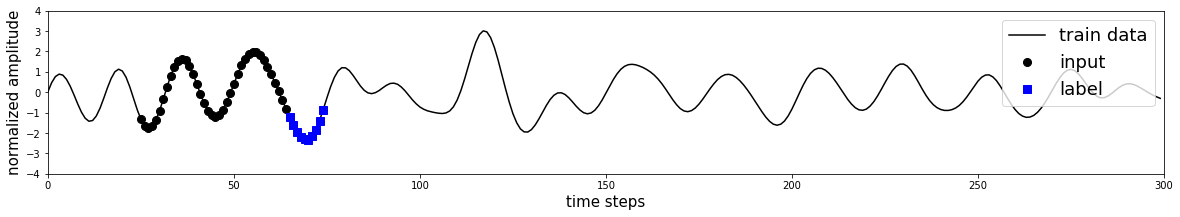

In [17]:
index_example = 25

X_example = data[index_example:index_example+n_steps_in]
y_example =  data[index_example+n_steps_in:index_example+n_steps_in+n_steps_out]

plt.figure(figsize=(20,3))
plt.plot(range(n_samples), data, 'k', label='train data')
plt.plot(np.arange(index_example, index_example + n_steps_in), X_example, "ko", markersize=8, label="input", linewidth=4)
plt.plot(np.arange(index_example + n_steps_in, index_example + n_steps_in + n_steps_out), y_example, "bs", markersize=8, label="label", linewidth=4)
plt.legend(loc="upper right", fontsize=18)
plt.axis([0, 300, -4, 4])
plt.xlabel('time steps', fontsize=15)
plt.ylabel('normalized amplitude', fontsize=15)

**`tf.contrib.rnn.OutputProjectionWrapper`를 이용한 RNN 구현**

In [49]:
reset_graph()

n_inputs = 1
n_outputs = 1
n_neurons = 200

X = tf.placeholder(tf.float32, [None, n_steps_in, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps_out, n_outputs])

# -----------basic RNN -----------------------------------
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

# -----------basic lstm -----------------------------------
# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons),
#     output_size=n_outputs)

# -----------basic GRU -----------------------------------
# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.CRUCell(num_units=n_neurons),
#     output_size=n_outputs)

outputs_all_steps, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
outputs = outputs_all_steps[:, -n_steps_out:, :]

learning_rate = 0.0005

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

batch_size = 30
n_epochs = 101
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_samples // batch_size):
            X_batch, y_batch = fetch_batch(batch_size, epoch, iteration)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})        
            print(epoch, "\tMSE:", mse)
    saver.save(sess, "./my_time_series_model")  


0 	MSE: 0.00038692937
10 	MSE: 0.008221537
20 	MSE: 0.003302273
30 	MSE: 0.0015154959
40 	MSE: 1.1482232e-05
50 	MSE: 6.977228e-06
60 	MSE: 1.1358698e-05
70 	MSE: 2.0146263e-05
80 	MSE: 1.338038e-05
90 	MSE: 0.0001848935
100 	MSE: 1.2115199e-05


**`tf.layers.dense`를 이용한 RNN 구현**

In [50]:
reset_graph()

n_inputs = 1
n_outputs = 1
n_neurons = 200

X = tf.placeholder(tf.float32, [None, n_steps_in, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps_out, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
# cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs,  n_outputs)
outputs_all_steps = tf.reshape(stacked_outputs, [-1, n_steps_in, n_outputs])
outputs = outputs_all_steps[:, -n_steps_out:, :]

learning_rate = 0.0005

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

batch_size = 30
n_epochs = 101
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_samples // batch_size):
            X_batch, y_batch = fetch_batch(batch_size, epoch, iteration)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})        
            print(epoch, "\tMSE:", mse)
    saver.save(sess, "./my_time_series_model")  

0 	MSE: 0.00018742502
10 	MSE: 0.018426392
20 	MSE: 8.186298e-05
30 	MSE: 0.00031512175
40 	MSE: 4.7725316e-06
50 	MSE: 4.656872e-06
60 	MSE: 1.3458519e-05
70 	MSE: 4.5086515e-05
80 	MSE: 1.9694148e-06
90 	MSE: 9.250254e-06
100 	MSE: 5.5021274e-06


INFO:tensorflow:Restoring parameters from ./my_time_series_model


Text(0,0.5,'normalized amplitude')

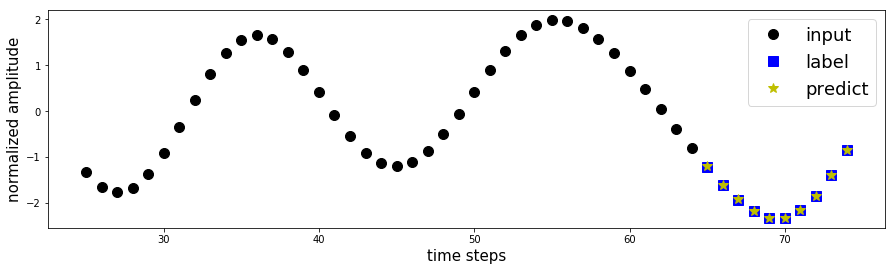

In [51]:
with tf.Session() as sess:                          
    saver.restore(sess, "./my_time_series_model")   
    index_example = 25
    X_example = data[index_example : index_example + n_steps_in]
    y_example =  data[index_example + n_steps_in  :index_example + n_steps_in + n_steps_out]
    y_pred = sess.run(outputs, feed_dict={X: X_example.reshape((1,-1,1))})
    
time = np.arange(n_steps_in + n_steps_out) + index_example
plt.figure(figsize=(15,4))
plt.plot(time[:40], X_example.reshape(-1), "ko", markersize=10, label="input")
plt.plot(time[40:],y_example.reshape(-1)[:], "bs", markersize=10, label="label")
plt.plot(time[40:],y_pred.reshape(-1)[:], "y*", markersize=10, label="predict")
plt.legend(loc="upper right", fontsize=18)

plt.xlabel('time steps', fontsize=15)
plt.ylabel('normalized amplitude', fontsize=15)

### 9.5 심층 RNN

In [53]:
reset_graph()

n_inputs = 1

n_outputs = 1
n_layers = 3

X = tf.placeholder(tf.float32, [None, n_steps_in, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps_out, n_outputs])


cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
              for layer in range(n_layers)]
# cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
#               for layer in range(n_layers)]
# cells = [tf.contrib.rnn.GRUCell(num_units=n_neurons)
#               for layer in range(n_layers)]

multi_cell = tf.contrib.rnn.MultiRNNCell(cells)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs,  n_outputs)
outputs_all_steps = tf.reshape(stacked_outputs, [-1, n_steps_in, n_outputs])
outputs = outputs_all_steps[:, -n_steps_out:, :]

learning_rate = 0.0005

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

batch_size = 30
n_epochs = 101
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_samples // batch_size):
            X_batch, y_batch = fetch_batch(batch_size, epoch, iteration)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})        
            print(epoch, "\tMSE:", mse)
    saver.save(sess, "./my_time_series_model")  


0 	MSE: 8.1959464e-05
10 	MSE: 0.008651232
20 	MSE: 0.0018053221
30 	MSE: 0.002050798
40 	MSE: 0.00052828016
50 	MSE: 5.546641e-06
60 	MSE: 4.7690035e-05
70 	MSE: 4.1306143e-06
80 	MSE: 1.225809e-05
90 	MSE: 0.0001204267
100 	MSE: 1.7966257e-05


INFO:tensorflow:Restoring parameters from ./my_time_series_model


Text(0,0.5,'normalized amplitude')

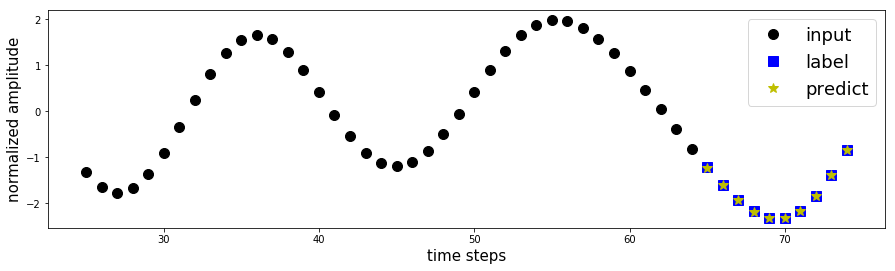

In [54]:
with tf.Session() as sess:                          
    saver.restore(sess, "./my_time_series_model")   
    index_example = 25
    X_example = data[index_example : index_example + n_steps_in]
    y_example =  data[index_example + n_steps_in  :index_example + n_steps_in + n_steps_out]
    y_pred = sess.run(outputs, feed_dict={X: X_example.reshape((1,-1,1))})
    
time = np.arange(n_steps_in + n_steps_out) + index_example
plt.figure(figsize=(15,4))
plt.plot(time[:40], X_example.reshape(-1), "ko", markersize=10, label="input")
plt.plot(time[40:],y_example.reshape(-1)[:], "bs", markersize=10, label="label")
plt.plot(time[40:],y_pred.reshape(-1)[:], "y*", markersize=10, label="predict")
plt.legend(loc="upper right", fontsize=18)

plt.xlabel('time steps', fontsize=15)
plt.ylabel('normalized amplitude', fontsize=15)